In [ ]:
# importing the necessary libraries to plot, manipulate the data set, and perform Lasso and ridge regression

library(data.table)
library(ggplot2)
library(dplyr)
library(MASS)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [ ]:
install.packages('glmnet')
library(glmnet)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘Rcpp’, ‘RcppEigen’




In [ ]:
install.packages('caret')
library(caret)

In [ ]:
#reading in the datasets, one for batting info, one for fielding info, one for pitching info

batting <- fread("career_batting (1).csv")
fielding <- fread("career_fielding (1).csv")
pitching <- fread("career_pitching (1).csv")

In [ ]:
#for each dataframe converts Y/N to 1/0 and coverts the type to numeric to be used in regression

batting$inducted[batting$inducted == 'Y'] <- 1
batting$inducted[batting$inducted == 'N'] <- 0
fielding$inducted[fielding$inducted == 'Y'] <- 1
fielding$inducted[fielding$inducted == 'N'] <- 0
pitching$inducted[pitching$inducted == 'Y'] <- 1
pitching$inducted[pitching$inducted == 'N'] <- 0

batting$inducted <- as.numeric(batting$inducted)
fielding$inducted <- as.numeric(fielding$inducted)
pitching$inducted <- as.numeric(pitching$inducted)

In [ ]:
#Removing the player_id, name_first and name_last columns

batting$player_id <- NULL
fielding$player_id <- NULL
pitching$player_id <- NULL
batting$name_first <- NULL
fielding$name_first <- NULL
pitching$name_first <- NULL
batting$name_last <- NULL
fielding$name_last <- NULL
pitching$name_last <- NULL

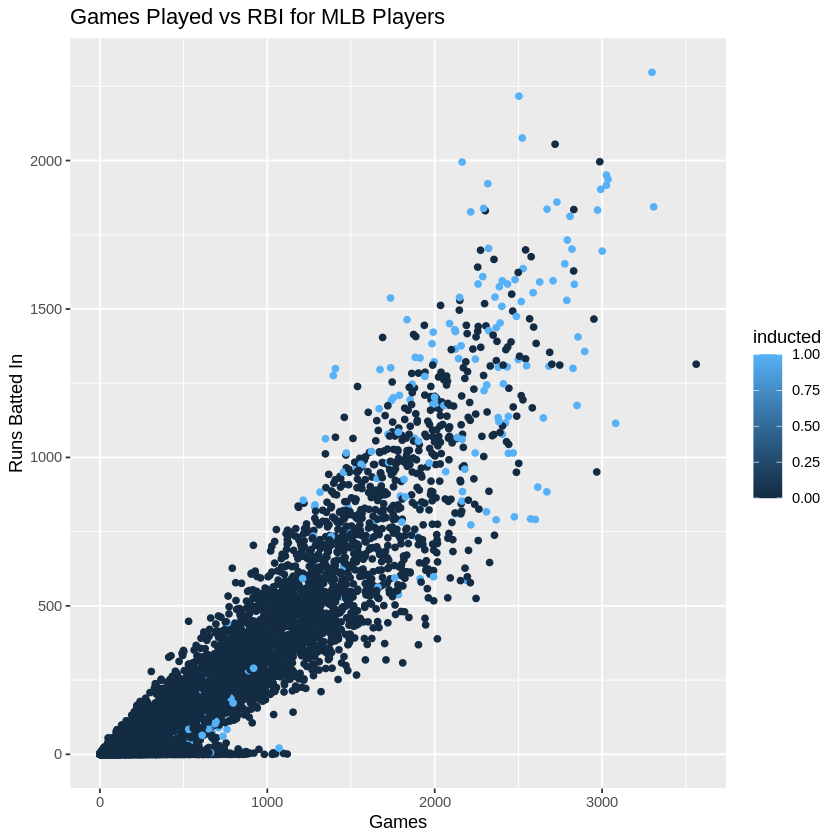

In [ ]:
# calculating batting average as hits per at bats

batting$bavg <- batting$h / batting$ab
batting_clean <- batting[!is.na(batting$bavg), ]

#Plot the relationship between games and RBI
ggplot(batting_clean, aes(x = g, y = rbi, col = inducted)) + geom_point() +
  labs(x = 'Games', y = "Runs Batted In", title = "Games Played vs RBI for MLB Players")

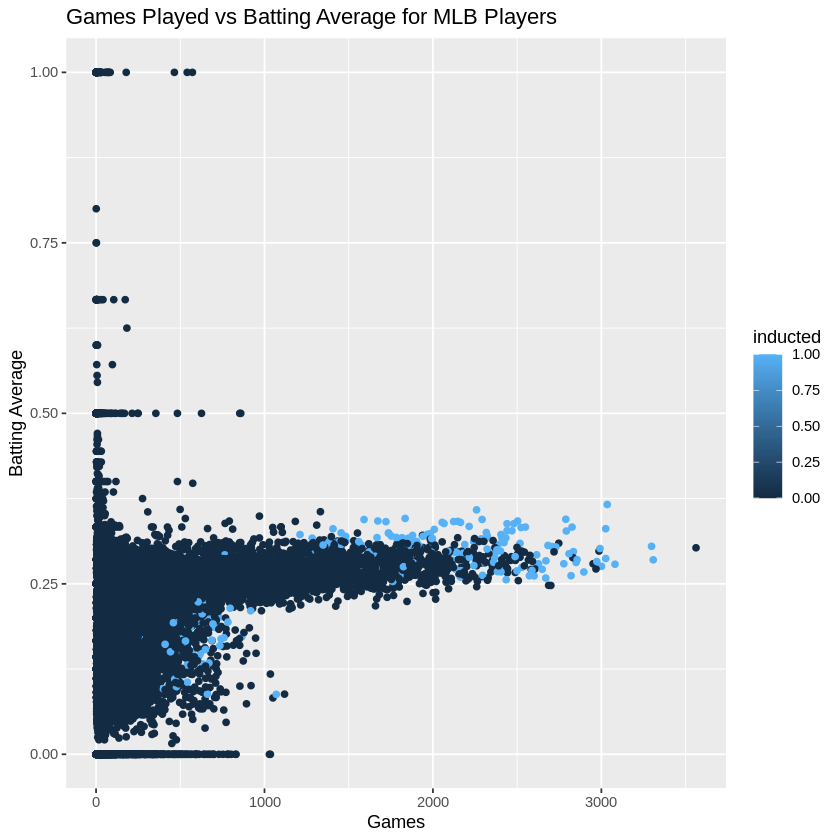

In [ ]:
#Plot the relationship between batting average and games played
ggplot(batting_clean, aes(x = g, y = bavg, col = inducted)) + geom_point() +
  labs(x = "Games", y = "Batting Average", title = "Games Played vs Batting Average for MLB Players")

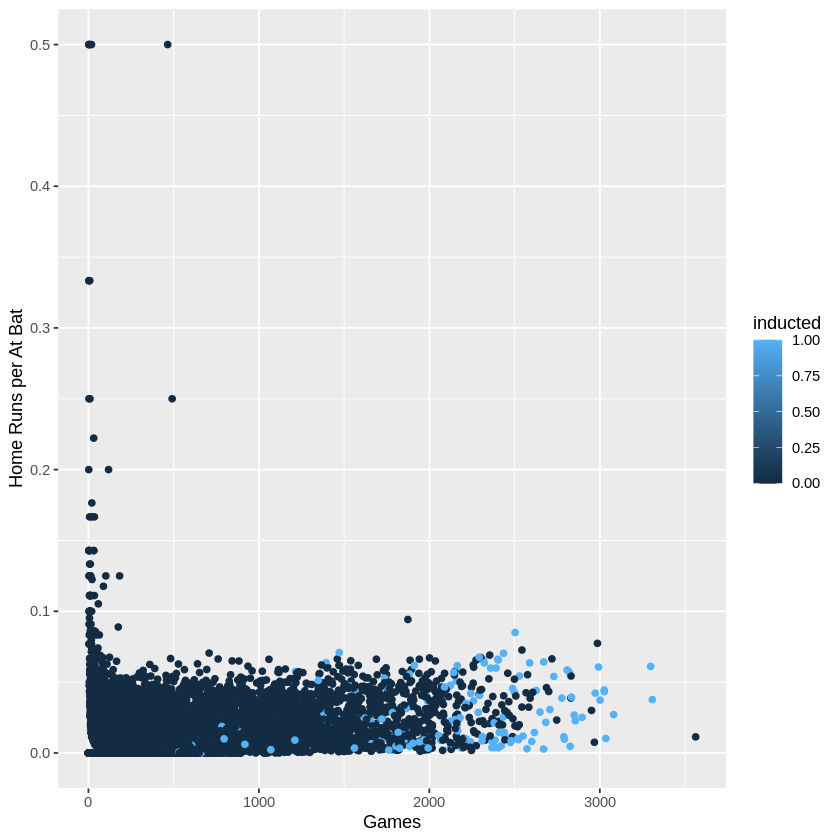

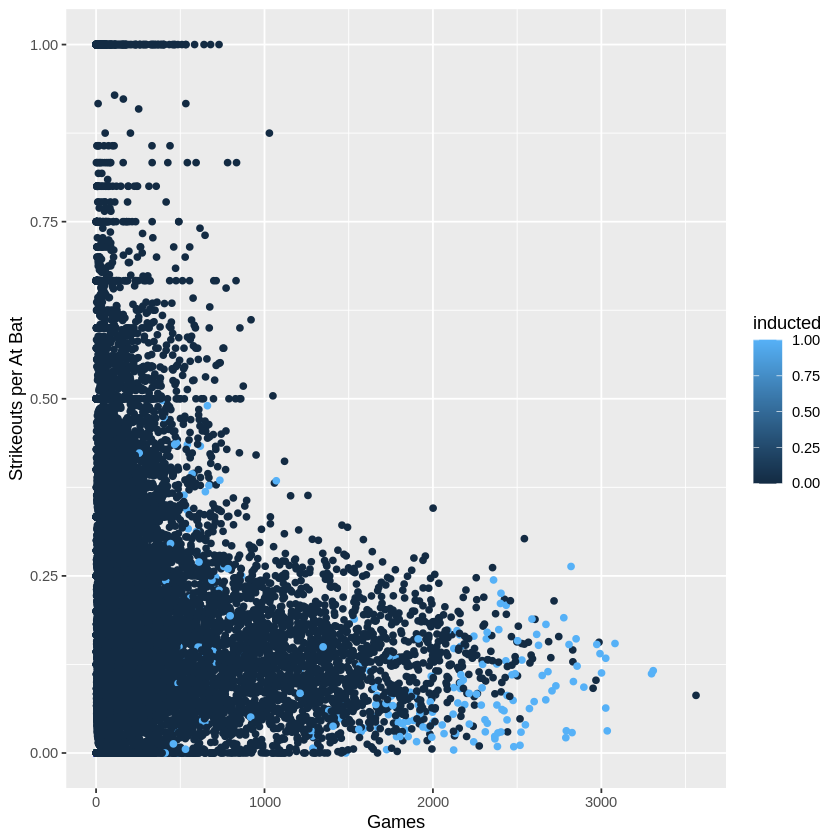

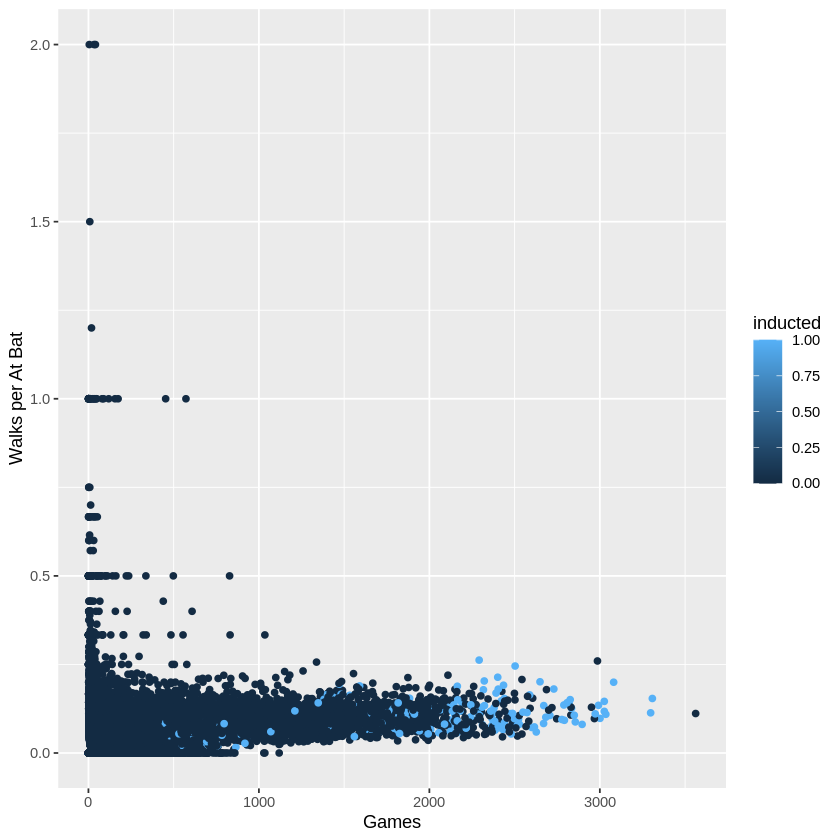

In [ ]:
#Plot the relationship between Home Runs, Strikeouts, and Walks per at bat and games played
batting_clean$hrr <- batting_clean$hr / batting_clean$ab
batting_clean$sor <- batting_clean$so / batting_clean$ab
batting_clean$bbr <- batting_clean$bb / batting_clean$ab

ggplot(batting_clean, aes(x = g, y = hrr, col = inducted)) + geom_point() + labs(x = "Games", y = "Home Runs per At Bat")
ggplot(batting_clean, aes(x = g, y = sor, col = inducted)) + geom_point() + labs(x = "Games", y = "Strikeouts per At Bat")
ggplot(batting_clean, aes(x = g, y = bbr, col = inducted)) + geom_point() + labs(x = "Games", y = "Walks per At Bat")

In [ ]:
#calculate fielding percentage as put outs plus assists over put outs plus assists plus errors

fielding$fpct <- (fielding$po + fielding$a) / (fielding$po + fielding$a + fielding$e)

In [ ]:
# removed NA data and infinite ERA (pitchers who recorded no outs)

fielding_clean <- fielding[!is.na(fielding$fpct), ]
pitching_clean <- pitching[!is.na(pitching$era), ]
pitching_clean <- pitching[!is.infinite(pitching$era), ]

Warning message:
“Removed 154 rows containing missing values (`geom_point()`).”


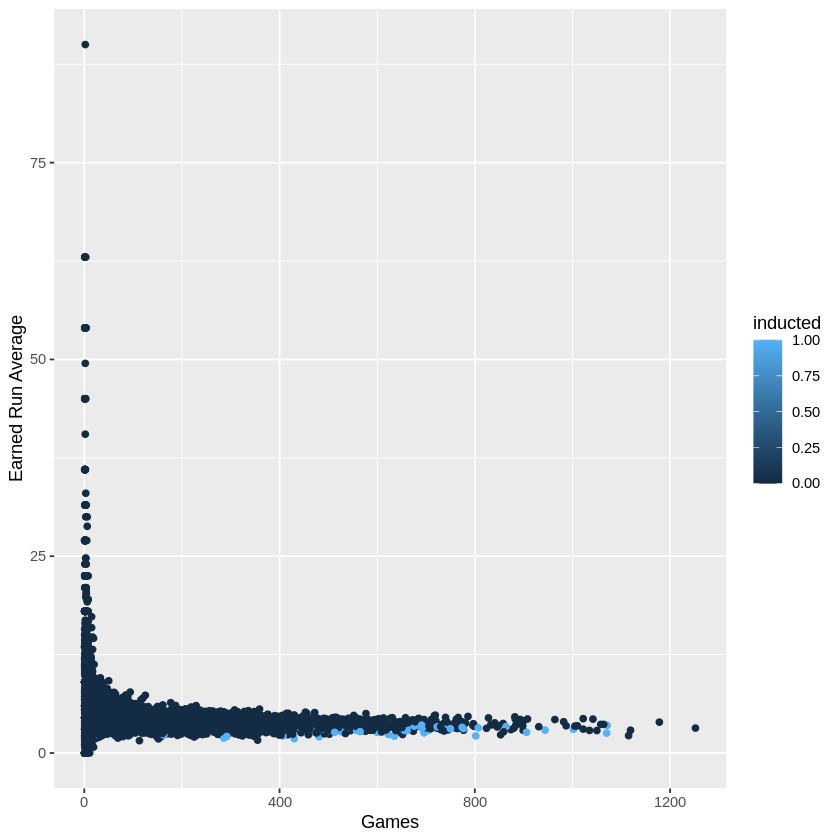

In [ ]:
#Plot the relationship between Earned Run Average (ERA) and games played

ggplot(pitching_clean, aes(x = g, y = era, col = inducted)) + geom_point() + labs(x = "Games", y = "Earned Run Average")

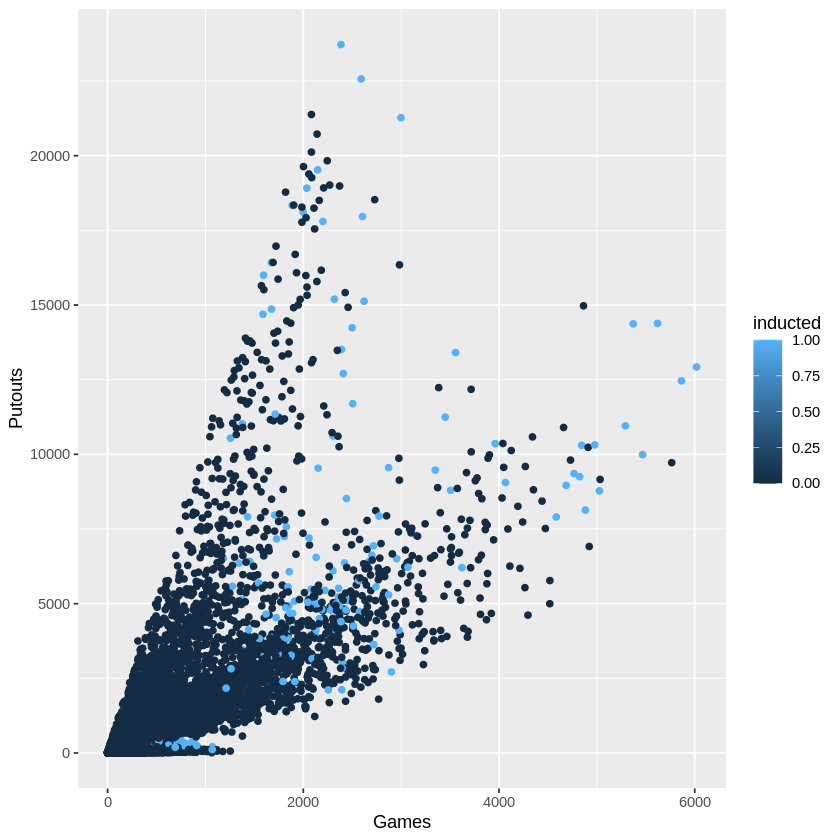

In [ ]:
#Plot the relationship between Putouts and games played
ggplot(fielding_clean, aes(x = g, y = po, col = inducted)) + geom_point() + labs(x = "Games", y = "Putouts")

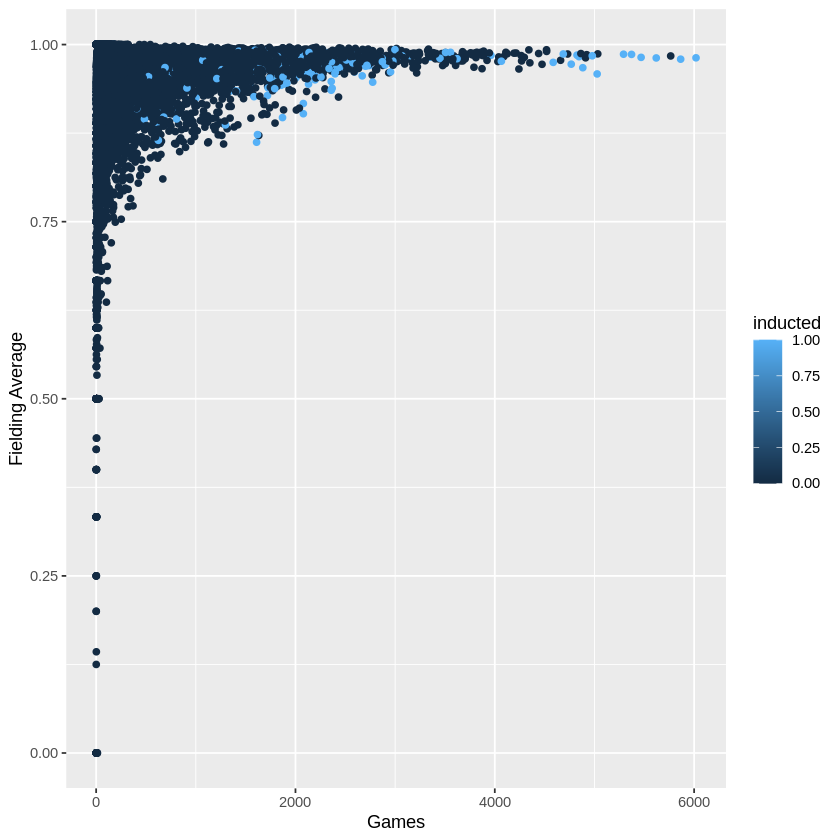

In [ ]:
#Plot the relationship between Fielding Average and games played

ggplot(fielding_clean, aes(x = g, y = fpct, col = inducted)) + geom_point() + labs(x = "Games", y = "Fielding Average")

In [ ]:
#a view of all variables in the data

str(batting_clean)
str(fielding_clean)
str(pitching_clean)

Classes ‘data.table’ and 'data.frame':	16666 obs. of  25 variables:
 $ V1        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ g         : num  331 3298 437 81 15 ...
 $ ab        : num  4 12364 944 5 21 ...
 $ r         : num  0 2174 102 0 1 ...
 $ h         : num  0 3771 216 0 2 ...
 $ double    : num  0 624 42 0 0 0 0 99 3 67 ...
 $ triple    : num  0 98 6 0 0 0 0 43 3 46 ...
 $ hr        : num  0 755 13 0 0 0 0 11 0 19 ...
 $ rbi       : num  0 2297 94 0 0 ...
 $ sb        : num  0 240 9 0 0 0 1 142 3 93 ...
 $ cs        : num  0 73 8 0 1 0 0 0 0 0 ...
 $ bb        : num  0 1402 86 0 4 ...
 $ so        : num  2 1383 145 3 5 ...
 $ ibb       : num  0 293 3 0 0 0 0 0 0 0 ...
 $ hbp       : num  0 32 0 0 0 0 0 33 0 23 ...
 $ sh        : num  1 21 9 0 0 0 0 93 4 18 ...
 $ sf        : num  0 121 6 0 0 0 0 0 0 0 ...
 $ g_idp     : num  0 328 36 0 1 1 0 0 0 0 ...
 $ start_year: num  2004 1954 1962 1989 2001 ...
 $ yearid    : num  NA 1982 NA NA NA ...
 $ inducted  : num  0 1 0 0 0 0 0 0 0 0 ...
 $ ba

In [ ]:
#Removing year_id column for all datasets
batting_clean$yearid <- NULL
fielding_clean$yearid <- NULL
pitching_clean$yearid <- NULL
pitching_clean$baopp <- NULL

In [ ]:
#splitting into test and training sets by which year a players started playing in the MLB for all 3 datasets

train_batting <- batting_clean %>% filter(start_year < 1960)
test_batting <- batting_clean %>% filter(start_year >= 1960)
train_fielding <- fielding_clean %>% filter(start_year < 1960)
test_fielding <- fielding_clean %>% filter(start_year >= 1960)
train_pitching <- pitching_clean %>% filter(start_year < 1960)
test_pitching <- pitching_clean %>% filter(start_year >= 1960)

In [ ]:
#checking for NA values

sum(is.na(batting_clean))

[1] 0

In [ ]:
#logistic regression

#fitting the model with limited variables
log_bat <- glm(inducted ~ g + rbi + bavg + hrr + sor + bbr, data = train_batting, family = binomial)
#using the model to predict
log_pred_bat <- predict(log_bat, newdata = test_batting, type = 'response')
#create pred1 and assign 1 or 0
pred1 <- rep(0, length(log_pred_bat))
pred1[log_pred_bat > 0.5] <- 1
#creating the confusion matrix
table(pred1, test_batting$inducted) #Accuracy = (7562 + 30) / (7562 + 30 + 92 + 22) = 7592 / 7706 = 98.52%

     
pred1    0    1
    0 7562   22
    1   92   30

In [ ]:
#MSE Value - Batting
mean((pred1 - test_batting$inducted)^2)

[1] 0.01479367

In [ ]:
# same but for fielding
log_field <- glm(inducted ~ g + po + fpct, data = train_fielding, family = binomial)
log_pred_field <- predict(log_field, newdata = test_fielding, type = 'response')
pred2 <- rep(0, length(log_pred_field))
pred2[log_pred_field > 0.5] <- 1
table(pred2, test_fielding$inducted) #Accuracy = (8261 + 23) / (8261 + 23 + 211 + 29) = 8284 / 8524 = 97.18%

     
pred2    0    1
    0 8621   29
    1  211   23

In [ ]:
#MSE Value - Fielding
mean((pred2 - test_fielding$inducted)^2)

[1] 0.02701486

In [ ]:
#same but for pitching
log_pitch <- glm(inducted ~ g + era, data = train_pitching, family = binomial)
log_pred_pitch <- predict(log_pitch, newdata = test_pitching, type = 'response')
pred3 <- rep(0, length(log_pred_pitch))
pred3[log_pred_pitch > 0.5] <- 1
table(pred3, test_pitching$inducted) # Accuracy = (4846 + 6) / (4846 + 6 + 37 + 15) = 4852 / 4904 = 98.94%

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


     
pred3    0    1
    0 4846   15
    1   37    6

In [ ]:
#MSE Value - Pitching
mean((pred3 - test_pitching$inducted)^2)

[1] 0.01060359

In [ ]:
install.packages('Metrics')
library(Metrics)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘Metrics’


The following objects are masked from ‘package:caret’:

    precision, recall




In [ ]:
#lda model

#fitting the lda model for batting
batting_lda <- lda(inducted ~ g + rbi + bavg + hrr + sor + bbr, data = train_batting, family = binomial)
#predicting on the lda model
batting_lda.pred <- predict(batting_lda, test_batting)$class
#the confusion matrix
table(batting_lda.pred, test_batting$inducted) #Accuracy = (7357 + 31) / (7357 + 31 + 297 + 21) = 7388 / 7706 = 95.87%

                
batting_lda.pred    0    1
               0 7357   21
               1  297   31

In [ ]:
#Test MSE for LDA - Batting
mse <- mse(test_batting$inducted, as.numeric(batting_lda.pred))
print(paste("Test MSE:", mse))

[1] "Test MSE: 1.11289903970932"


In [ ]:
#repeat for fielding
fielding_lda <- lda(inducted ~ g + po + fpct, data = train_fielding, family = binomial)
fielding_lda.pred <- predict(fielding_lda, test_fielding)$class
table(fielding_lda.pred, test_fielding$inducted) #Accuracy = (8226 + 32) / (8226 + 32 + 606 + 20) = 8258 / 8884 = 92.95%

                 
fielding_lda.pred    0    1
                0 8226   20
                1  606   32

In [ ]:
#Test MSE for LDA - Fielding
mse <- mse(test_fielding$inducted, as.numeric(fielding_lda.pred))
print(paste("Test MSE:", mse))

[1] "Test MSE: 1.20238631247186"


In [ ]:
#repeat for pitching
pitching_lda <- lda(inducted ~ g + era, data = train_pitching, family = binomial)
pitching_lda.pred <- predict(pitching_lda, test_pitching)$class
table(pitching_lda.pred, test_pitching$inducted) #Accuracy = (4560 + 20) / (4560 + 20 + 323 + 1) = 4580 / 4904 = 93.39%

                 
pitching_lda.pred    0    1
                0 4560    1
                1  323   20

In [ ]:
#Test MSE for LDA - Pitching
mse <- mse(test_pitching$inducted, as.numeric(pitching_lda.pred))
print(paste("Test MSE:", mse))

[1] "Test MSE: 1.1973898858075"


In [ ]:
#qda model

#fit the qda model for batting
batting_qda <- qda(inducted ~ g + rbi + bavg + hrr + sor + bbr, data = train_batting, family = binomial)
#predicting on training data
batting_qda.pred <- predict(batting_qda, test_batting)$class
#creating the confusion matrix
table(batting_qda.pred, test_batting$inducted) #Accuracy: (6881 + 37) / 7706 = 89.77%

                
batting_qda.pred    0    1
               0 6881   15
               1  773   37

In [ ]:
#Test MSE for QDA - Batting
mse <- mse(test_batting$inducted, as.numeric(batting_qda.pred))
print(paste("Test MSE:", mse))

[1] "Test MSE: 1.29898780171295"


In [ ]:
#repeat for fielding
fielding_qda <- qda(inducted ~ g + po + fpct, data = train_fielding, family = binomial)
fielding_qda.pred <- predict(fielding_qda, test_fielding)$class
table(fielding_qda.pred, test_fielding$inducted) #Accuracy: 8090 / 8884 = 91.06%

                 
fielding_qda.pred    0    1
                0 8057   19
                1  775   33

In [ ]:
#Test MSE for QDA - Fielding
mse <- mse(test_fielding$inducted, as.numeric(fielding_qda.pred))
print(paste("Test MSE:", mse))

[1] "Test MSE: 1.25956776226925"


In [ ]:
#repeat for pitching
pitching_qda <- qda(inducted ~ g + era, data = train_pitching, family = binomial)
pitching_qda.pred <- predict(pitching_qda, test_pitching)$class
table(pitching_qda.pred, test_pitching$inducted) #Accuracy = 4534 / 4904 = 92.46%

                 
pitching_qda.pred    0    1
                0 4514    1
                1  369   20

In [ ]:
#Test MSE for QDA - Pitching
mse <- mse(test_pitching$inducted, as.numeric(pitching_qda.pred))
print(paste("Test MSE:", mse))

[1] "Test MSE: 1.22553017944535"


In [ ]:
# Lasso/Ridge

In [ ]:
#set seed for reproducibility
set.seed(20)

In [ ]:
#define variables for batting
X_train <- data.matrix(train_batting[, -c('V1', 'player_id', 'start_year', 'first_name', 'last_name', 'year_id', 'inducted')])
y_train <- train_batting$inducted

X_test <- data.matrix(test_batting[, -c('V1', 'player_id', 'start_year', 'first_name', 'last_name', 'year_id', 'inducted')])
y_test <- test_batting$inducted

# Ridge Regression (alpha = 0)
cv_ridge <- cv.glmnet(X_train, y_train, alpha = 0)
best_lambda_ridge <- cv_ridge$lambda.min
ridge_model <- glmnet(X_train, y_train, alpha = 0, lambda = best_lambda_ridge)

# Lasso Regression (alpha = 1)
cv_lasso <- cv.glmnet(X_train, y_train, alpha = 1)
best_lambda_lasso <- cv_lasso$lambda.min
lasso_model <- glmnet(X_train, y_train, alpha = 1, lambda = best_lambda_lasso)

# Predictions
pred_ridge <- predict(ridge_model, s=best_lambda_ridge, newx = X_test)
pred_lasso <- predict(lasso_model, s=best_lambda_lasso, newx = X_test)

# Convert probabilities to binary class predictions
pred_ridge_class <- ifelse(pred_ridge > 0.5, 1, 0)
pred_lasso_class <- ifelse(pred_lasso > 0.5, 1, 0)

print(mean((pred_ridge - y_test)^2)) #Test MSE for Ridge - 0.0082
print(mean((pred_lasso - y_test)^2)) #Test MSE for LASSO - 0.0087

# Evaluate the models
library(caret)
confusionMatrix(as.factor(pred_ridge_class), as.factor(y_test))
confusionMatrix(as.factor(pred_lasso_class), as.factor(y_test))

Warning message:
“column(s) not removed because not found: [player_id, first_name, last_name, year_id]”
Warning message:
“column(s) not removed because not found: [player_id, first_name, last_name, year_id]”


[1] 0.008169369
[1] 0.008714588


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 7637   42
         1   17   10
                                          
               Accuracy : 0.9923          
                 95% CI : (0.9901, 0.9942)
    No Information Rate : 0.9933          
    P-Value [Acc > NIR] : 0.851401        
                                          
                  Kappa : 0.2497          
                                          
 Mcnemar's Test P-Value : 0.001781        
                                          
            Sensitivity : 0.9978          
            Specificity : 0.1923          
         Pos Pred Value : 0.9945          
         Neg Pred Value : 0.3704          
             Prevalence : 0.9933          
         Detection Rate : 0.9910          
   Detection Prevalence : 0.9965          
      Balanced Accuracy : 0.5950          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 7634   40
         1   20   12
                                        
               Accuracy : 0.9922        
                 95% CI : (0.99, 0.9941)
    No Information Rate : 0.9933        
    P-Value [Acc > NIR] : 0.88002       
                                        
                  Kappa : 0.282         
                                        
 Mcnemar's Test P-Value : 0.01417       
                                        
            Sensitivity : 0.9974        
            Specificity : 0.2308        
         Pos Pred Value : 0.9948        
         Neg Pred Value : 0.3750        
             Prevalence : 0.9933        
         Detection Rate : 0.9907        
   Detection Prevalence : 0.9958        
      Balanced Accuracy : 0.6141        
                                        
       'Positive' Class : 0             
                                        

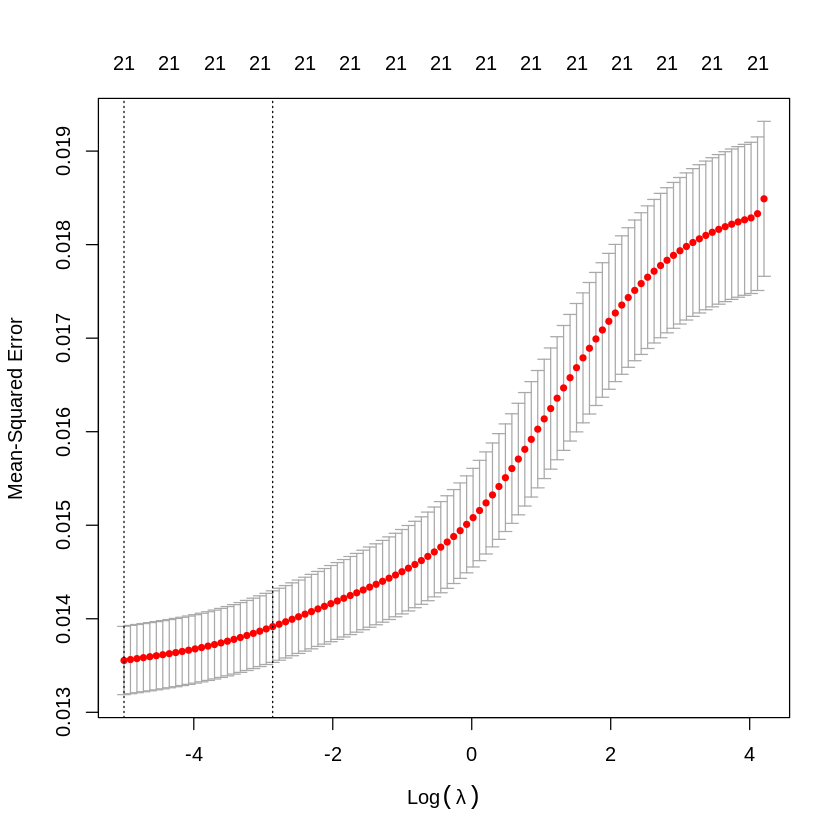

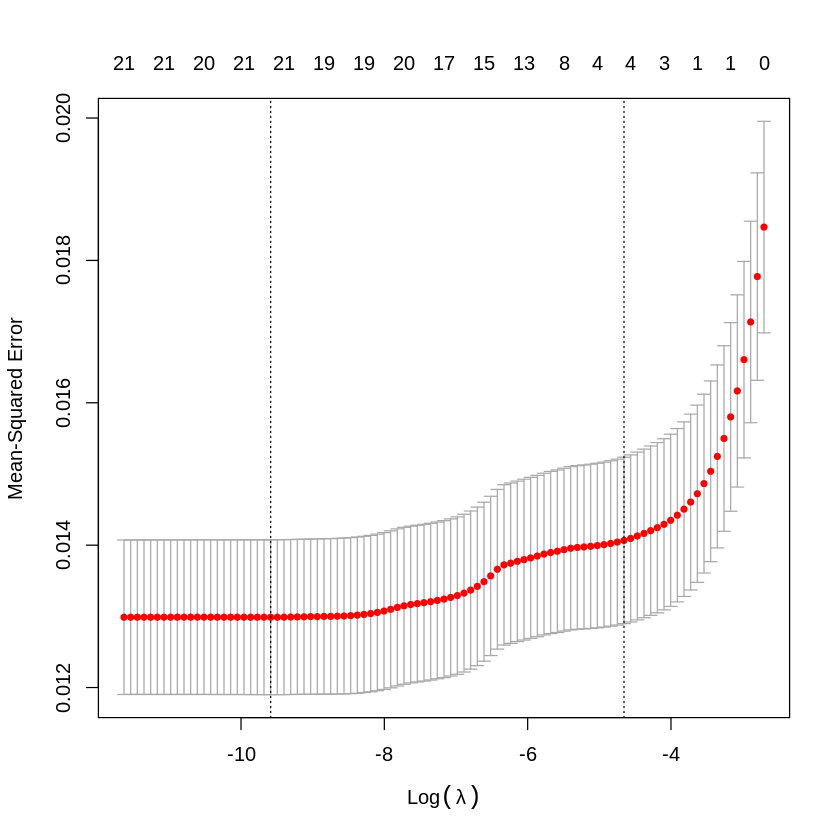

In [ ]:
#plots of MSE by lambda value for each batting ridge and lasso model
plot(cv_ridge)
plot(cv_lasso)

In [ ]:
#view coefficients used in model
coef(cv_ridge)
coef(cv_lasso)

22 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept) -3.592152e-03
g            3.533199e-07
ab          -3.616203e-07
r            4.112875e-05
h            1.378891e-05
double       1.135402e-04
triple       4.233462e-04
hr           4.582257e-04
rbi          6.033851e-05
sb           2.135215e-05
cs          -2.200404e-04
bb           3.523951e-05
so          -1.643880e-05
ibb          7.775460e-04
hbp         -1.505035e-04
sh           1.297078e-04
sf          -7.769203e-04
g_idp       -1.100136e-04
bavg        -2.445260e-02
hrr         -1.283718e-01
sor          1.414893e-02
bbr         -1.515904e-02

22 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept) -4.986190e-03
g            .           
ab           .           
r            1.316934e-05
h            .           
double       .           
triple       3.709952e-04
hr           3.530541e-04
rbi          1.631522e-04
sb           .           
cs           .           
bb           .           
so           .           
ibb          .           
hbp          .           
sh           .           
sf           .           
g_idp        .           
bavg         .           
hrr          .           
sor          .           
bbr          .           

In [ ]:
#define variables for fielding
X_train <- data.matrix(train_fielding[, -c('V1', 'player_id', 'start_year', 'first_name', 'last_name', 'year_id', 'inducted')])
y_train <- train_fielding$inducted

X_test <- data.matrix(test_fielding[, -c('V1', 'player_id', 'start_year', 'first_name', 'last_name', 'year_id', 'inducted')])
y_test <- test_fielding$inducted

# Ridge Regression (alpha = 0)
cv_ridge <- cv.glmnet(X_train, y_train, alpha = 0)
best_lambda_ridge <- cv_ridge$lambda.min
ridge_model <- glmnet(X_train, y_train, alpha = 0, lambda = best_lambda_ridge)

# Lasso Regression (alpha = 1)
cv_lasso <- cv.glmnet(X_train, y_train, alpha = 1)
best_lambda_lasso <- cv_lasso$lambda.min
lasso_model <- glmnet(X_train, y_train, alpha = 1, lambda = best_lambda_lasso)

# Predictions
pred_ridge <- predict(ridge_model, s=best_lambda_ridge, newx = X_test)
pred_lasso <- predict(lasso_model, s=best_lambda_lasso, newx = X_test)

# Convert probabilities to binary class predictions
pred_ridge_class <- ifelse(pred_ridge > 0.5, 1, 0)
pred_lasso_class <- ifelse(pred_lasso > 0.5, 1, 0)

print(mean((pred_ridge - y_test)^2)) #Test MSE for Ridge - 0.0084
print(mean((pred_lasso - y_test)^2)) #Test MSE for LASSO - 0.0073

# Evaluate the models
library(caret)
confusionMatrix(as.factor(pred_ridge_class), as.factor(y_test))
confusionMatrix(as.factor(pred_lasso_class), as.factor(y_test))

Warning message:
“column(s) not removed because not found: [player_id, first_name, last_name, year_id]”
Warning message:
“column(s) not removed because not found: [player_id, first_name, last_name, year_id]”


[1] 0.00839401
[1] 0.007314951


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8831   50
         1    1    2
                                          
               Accuracy : 0.9943          
                 95% CI : (0.9925, 0.9957)
    No Information Rate : 0.9941          
    P-Value [Acc > NIR] : 0.4814          
                                          
                  Kappa : 0.0721          
                                          
 Mcnemar's Test P-Value : 1.801e-11       
                                          
            Sensitivity : 0.99989         
            Specificity : 0.03846         
         Pos Pred Value : 0.99437         
         Neg Pred Value : 0.66667         
             Prevalence : 0.99415         
         Detection Rate : 0.99403         
   Detection Prevalence : 0.99966         
      Balanced Accuracy : 0.51917         
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8832   49
         1    0    3
                                          
               Accuracy : 0.9945          
                 95% CI : (0.9927, 0.9959)
    No Information Rate : 0.9941          
    P-Value [Acc > NIR] : 0.3717          
                                          
                  Kappa : 0.1085          
                                          
 Mcnemar's Test P-Value : 7.025e-12       
                                          
            Sensitivity : 1.00000         
            Specificity : 0.05769         
         Pos Pred Value : 0.99448         
         Neg Pred Value : 1.00000         
             Prevalence : 0.99415         
         Detection Rate : 0.99415         
   Detection Prevalence : 0.99966         
      Balanced Accuracy : 0.52885         
                                          
       'Positive' Class : 0               
                        

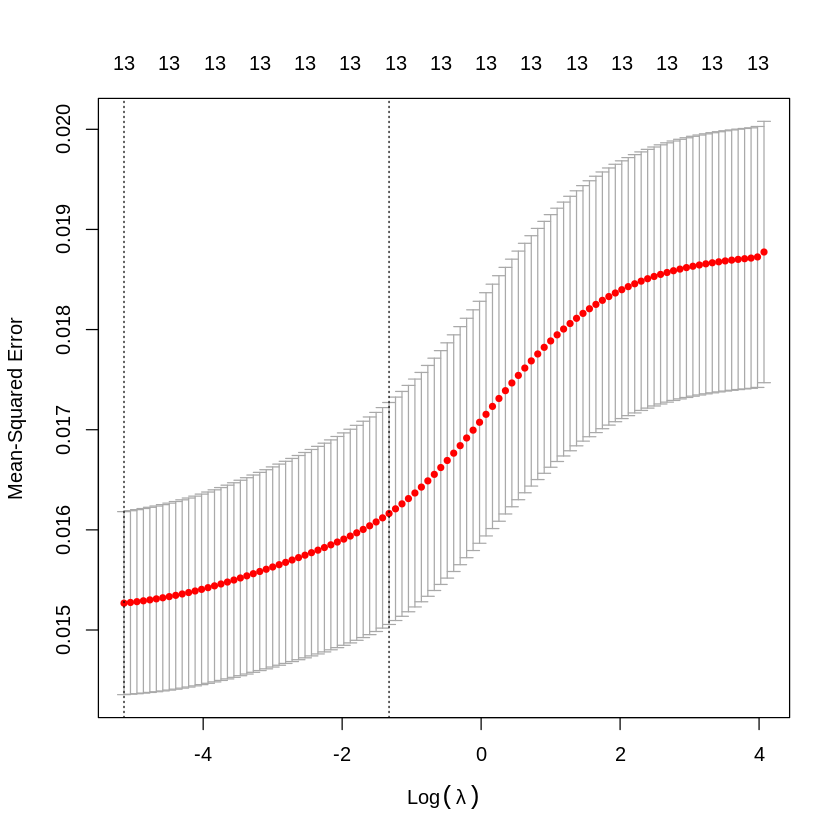

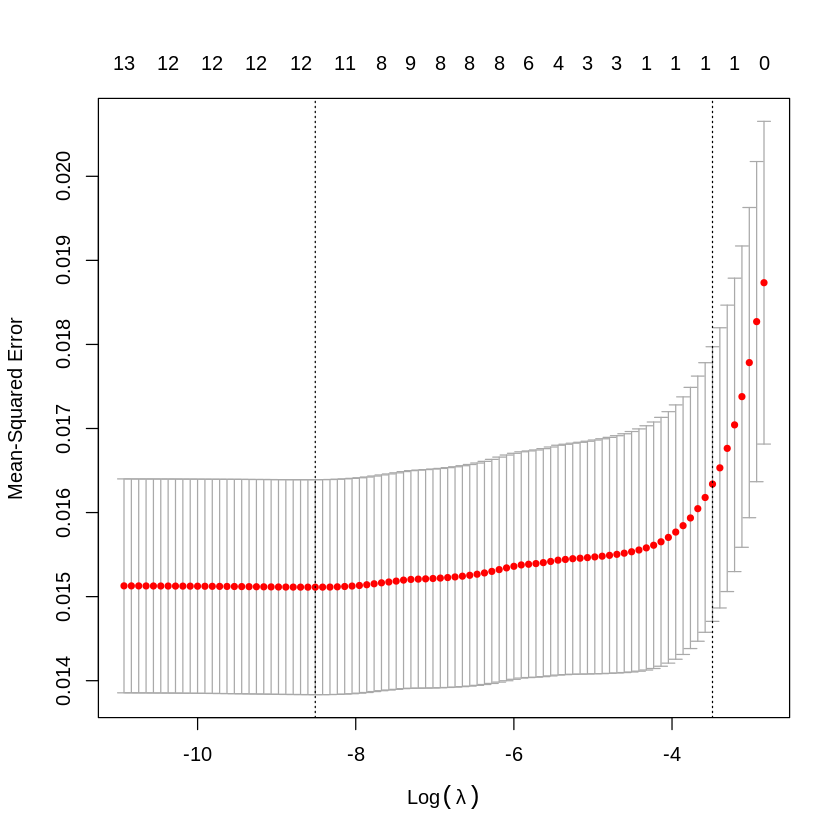

In [ ]:
#more plots of mse by lambda for ridge and lasso for fielding
plot(cv_ridge)
plot(cv_lasso)

In [ ]:
#view coefficients used in model
coef(cv_ridge)
coef(cv_lasso)

14 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept) -2.940443e-03
g            2.696382e-05
gs           1.386696e-05
inn_outs     4.392986e-07
po           4.437497e-06
a            9.021567e-06
e            5.427285e-05
dp           3.600165e-05
pb           4.974345e-06
wp          -4.664318e-05
sb          -3.856850e-05
cs          -1.976992e-05
zr          -6.760871e-04
fpct         5.057742e-03

14 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) 3.975277e-03
g           5.972613e-05
gs          .           
inn_outs    .           
po          .           
a           .           
e           .           
dp          .           
pb          .           
wp          .           
sb          .           
cs          .           
zr          .           
fpct        .           

In [ ]:
#define variables for pitching
X_train <- data.matrix(train_pitching[, -c('V1', 'player_id', 'start_year', 'first_name', 'last_name', 'year_id', 'inducted')])
y_train <- train_pitching$inducted

X_test <- data.matrix(test_pitching[, -c('V1', 'player_id', 'start_year', 'first_name', 'last_name', 'year_id', 'inducted')])
y_test <- test_pitching$inducted

# Ridge Regression (alpha = 0)
cv_ridge <- cv.glmnet(X_train, y_train, alpha = 0)
best_lambda_ridge <- cv_ridge$lambda.min
ridge_model <- glmnet(X_train, y_train, alpha = 0, lambda = best_lambda_ridge)

# Lasso Regression (alpha = 1)
cv_lasso <- cv.glmnet(X_train, y_train, alpha = 1)
best_lambda_lasso <- cv_lasso$lambda.min
lasso_model <- glmnet(X_train, y_train, alpha = 1, lambda = best_lambda_lasso)

# Predictions
pred_ridge <- predict(ridge_model, s=best_lambda_ridge, newx = X_test)
pred_lasso <- predict(lasso_model, s=best_lambda_lasso, newx = X_test)

# Convert probabilities to binary class predictions
pred_ridge_class <- ifelse(pred_ridge > 0.5, 1, 0)
pred_lasso_class <- ifelse(pred_lasso > 0.5, 1, 0)

print(mean((pred_ridge - y_test)^2)) #Test MSE for Ridge - 0.0034
print(mean((pred_lasso - y_test)^2)) #Test MSE for LASSO - 0.0041

# Evaluate the models
library(caret)
confusionMatrix(as.factor(pred_ridge_class), as.factor(y_test))
confusionMatrix(as.factor(pred_lasso_class), as.factor(y_test))


Warning message:
“column(s) not removed because not found: [player_id, first_name, last_name, year_id]”
Warning message:
“column(s) not removed because not found: [player_id, first_name, last_name, year_id]”


[1] 0.00343954
[1] 0.004115691


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4881   16
         1    2    5
                                          
               Accuracy : 0.9963          
                 95% CI : (0.9942, 0.9978)
    No Information Rate : 0.9957          
    P-Value [Acc > NIR] : 0.301199        
                                          
                  Kappa : 0.3558          
                                          
 Mcnemar's Test P-Value : 0.002183        
                                          
            Sensitivity : 0.9996          
            Specificity : 0.2381          
         Pos Pred Value : 0.9967          
         Neg Pred Value : 0.7143          
             Prevalence : 0.9957          
         Detection Rate : 0.9953          
   Detection Prevalence : 0.9986          
      Balanced Accuracy : 0.6188          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4880   10
         1    3   11
                                          
               Accuracy : 0.9973          
                 95% CI : (0.9955, 0.9986)
    No Information Rate : 0.9957          
    P-Value [Acc > NIR] : 0.04304         
                                          
                  Kappa : 0.6273          
                                          
 Mcnemar's Test P-Value : 0.09609         
                                          
            Sensitivity : 0.9994          
            Specificity : 0.5238          
         Pos Pred Value : 0.9980          
         Neg Pred Value : 0.7857          
             Prevalence : 0.9957          
         Detection Rate : 0.9951          
   Detection Prevalence : 0.9971          
      Balanced Accuracy : 0.7616          
                                          
       'Positive' Class : 0               
                        

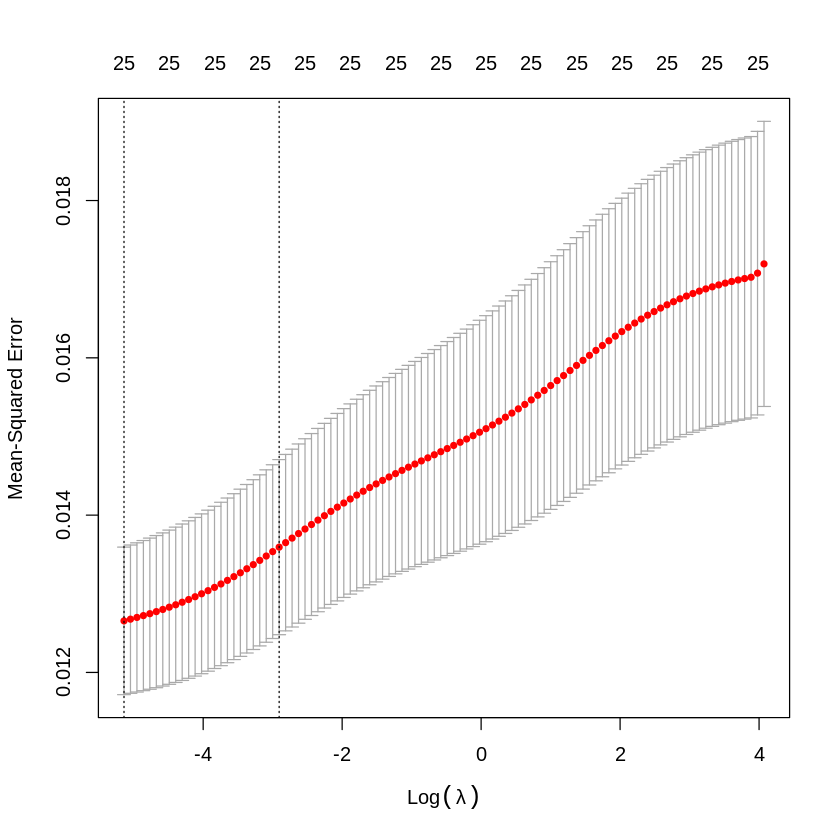

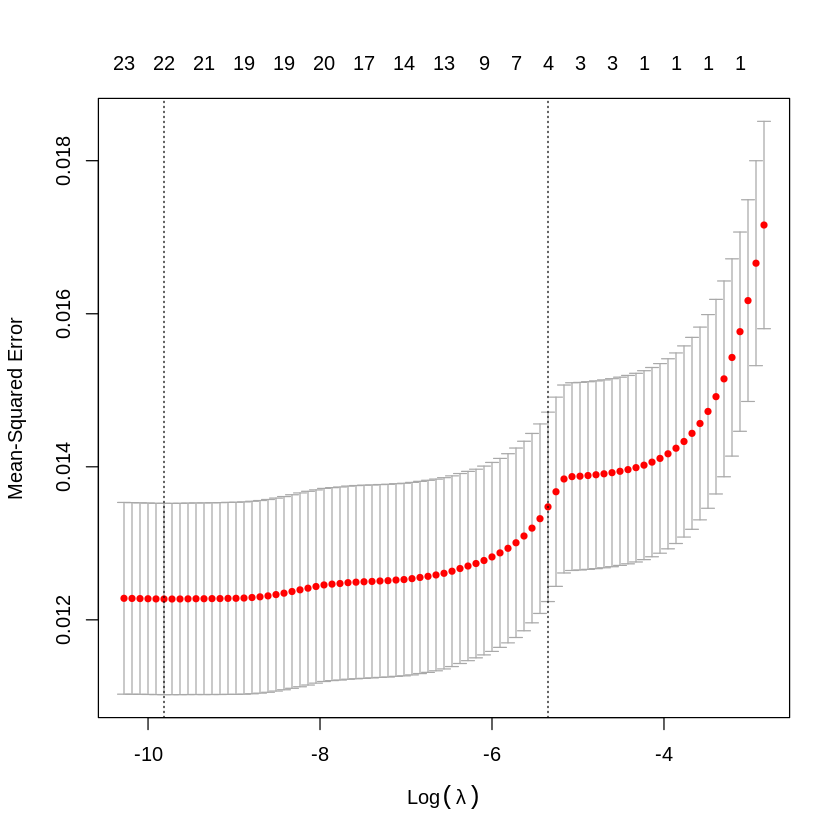

In [62]:
#plots of mse by lambda for lasso and ridge for pitching
plot(cv_ridge)
plot(cv_lasso)

In [63]:
#view coefficients used in model
coef(cv_ridge)
coef(cv_lasso)

26 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept) -3.467998e-03
w            2.907300e-04
l           -2.094734e-04
g           -2.423828e-05
gs           2.194960e-05
cg           1.950373e-04
sho          2.705164e-03
sv           4.275276e-04
ipouts       1.755119e-06
h           -3.756394e-07
er          -2.135812e-05
hr          -5.514458e-05
bb          -2.020309e-05
so           4.802937e-05
era          2.393199e-04
ibb         -1.483357e-04
wp           1.593454e-04
hbp         -8.690702e-05
bk          -9.102442e-04
bfp          2.734154e-06
gf          -1.245880e-04
r           -1.724472e-05
sh          -3.383886e-04
sf          -3.547572e-04
g_idp       -8.598260e-04
ip           5.127649e-06

26 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept) -3.435189e-03
w            .           
l           -4.673666e-04
g            .           
gs           .           
cg           1.914320e-04
sho          5.873454e-03
sv           .           
ipouts       .           
h            .           
er           .           
hr           .           
bb           .           
so           4.456271e-05
era          .           
ibb          .           
wp           .           
hbp          .           
bk           .           
bfp          .           
gf           .           
r            .           
sh           .           
sf           .           
g_idp        .           
ip           .           

In [64]:
# Trees

#install packages for trees
install.packages('randomForest')
install.packages('gbm')
install.packages('tree')
library(tree)
library(randomForest)
library(gbm)

#fit a model using all the data
tree.batting <- tree(inducted ~ ., data = train_batting)
summary(tree.batting) #Number of Terminal Nodes: 13, Residual Mean Deviance: 0.0078

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loaded gbm 2.1.9

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3




Regression tree:
tree(formula = inducted ~ ., data = train_batting)
Variables actually used in tree construction:
[1] "h"     "rbi"   "sh"    "r"     "sb"    "bavg"  "g"     "cs"    "g_idp"
Number of terminal nodes:  13 
Residual mean deviance:  0.007826 = 70.02 / 8947 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.978300 -0.003736 -0.003736  0.000000 -0.003736  0.996300 

In [65]:
#set seed for reproducibility
set.seed(470)

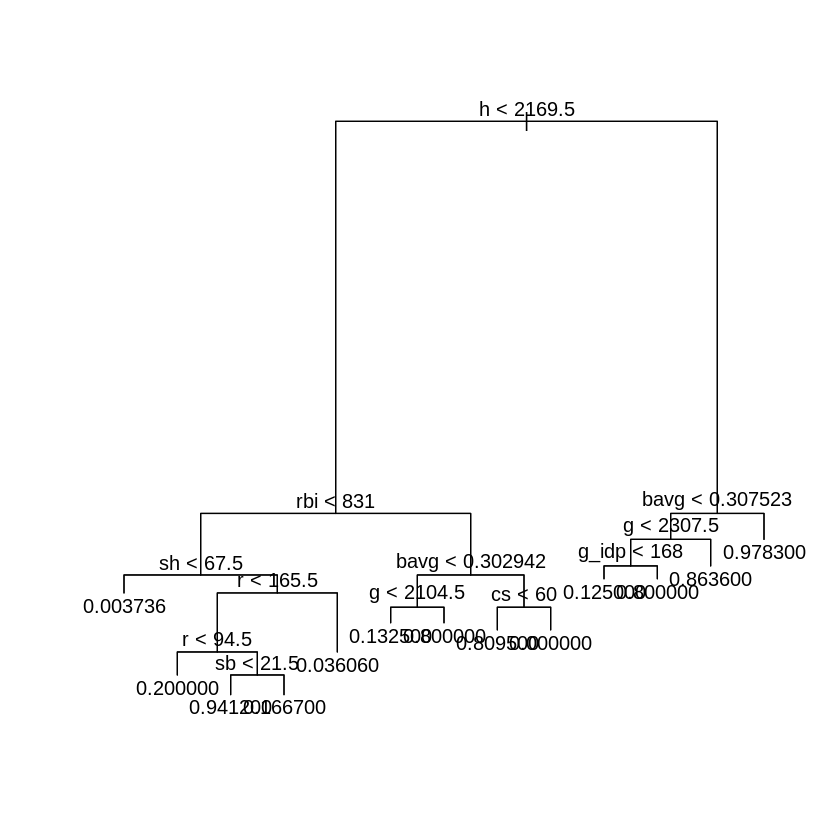

In [66]:
#plot the model for batting
plot(tree.batting)
text(tree.batting, pretty = 0)

In [67]:
#use the tree to predict
batting_tree.pred <- predict(tree.batting, test_batting)
batting_tree.test <- test_batting$inducted
#calculate MSE
mean((batting_tree.pred - batting_tree.test)^2) #MSE: 0.0106

[1] 0.01061649

In [68]:
# assessing results and constructing confusion matrix
batting_tree.table <- rep(0, length(batting_tree.pred))
batting_tree.table[batting_tree.pred > 0.5] <- 1
table(batting_tree.table, batting_tree.test)

                  batting_tree.test
batting_tree.table    0    1
                 0 7569   18
                 1   85   34

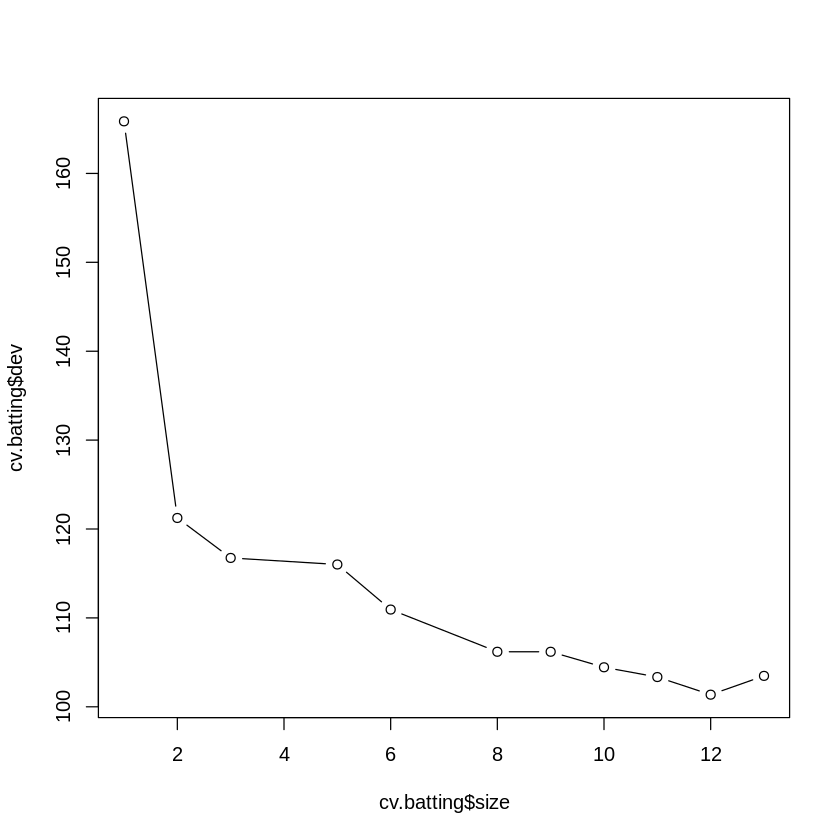

In [69]:
#model size vs dev
cv.batting <- cv.tree(tree.batting)
plot(cv.batting$size, cv.batting$dev, type = 'b')

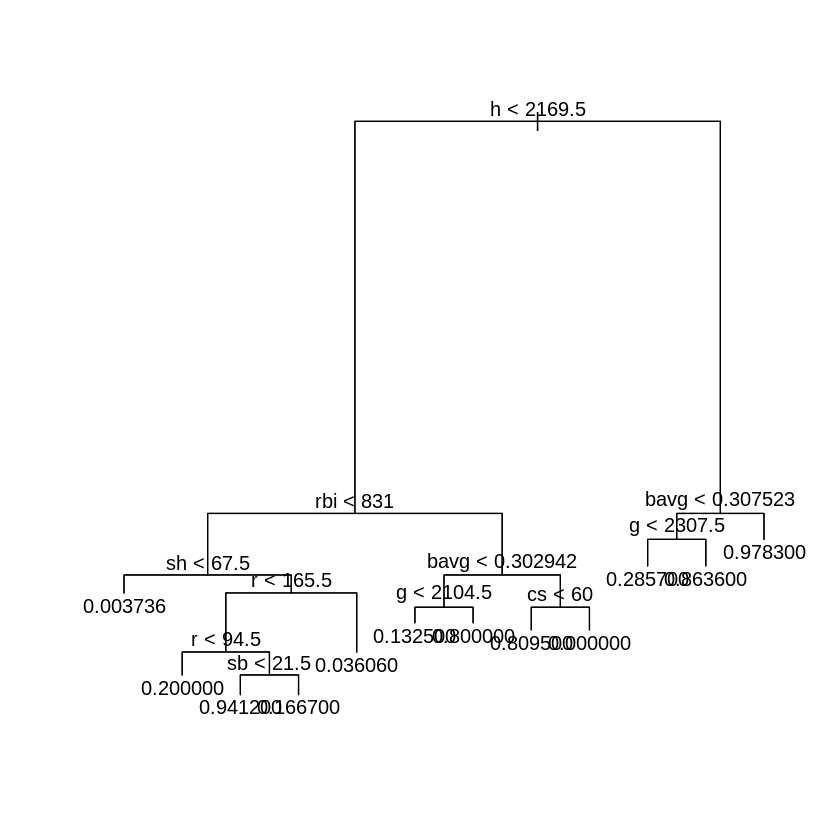

In [70]:
#pruning the tre for better results
prune.batting = prune.tree(tree.batting, best= 12)
plot(prune.batting)
text(prune.batting, pretty = 0)

In [71]:
#repredicting on the pruned tree
pruned_batting.pred <- predict(prune.batting, test_batting)
mean((pruned_batting.pred - batting_tree.test)^2) #0.0096

[1] 0.009637383

In [72]:
#new confusion matrix for the pruned tree
pruned_batting.table <- rep(0, length(pruned_batting.pred))
pruned_batting.table[pruned_batting.pred > 0.5] <- 1
table(pruned_batting.table, batting_tree.test)

                    batting_tree.test
pruned_batting.table    0    1
                   0 7586   21
                   1   68   31

In [73]:
#fitting a bagging model
bag.batting <- randomForest(inducted ~ ., data = train_batting, importance = TRUE)
#predicting using the bagging model
yhatb.bag <- predict(bag.batting, newdata = test_batting)
mean((yhatb.bag - batting_tree.test)^2) #0.0093

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.009327411

In [74]:
#assessing results with MSE and confusion matrix
yhatb.bag.table <- rep(0, length(yhatb.bag))
yhatb.bag.table[yhatb.bag > 0.5] <- 1
table(yhatb.bag.table, batting_tree.test)

               batting_tree.test
yhatb.bag.table    0    1
              0 7581   19
              1   73   33

In [75]:
#Determining the most important values for forming the decision tree
importance(bag.batting) #bavg and g

,%IncMSE,IncNodePurity
V1,-0.9575003,3.6171639
g,18.0033035,9.5041439
ab,12.9556750,10.1353087
r,16.9931052,19.0598772
h,16.0073027,22.9384907
double,12.6521356,11.8637236
triple,9.1812133,4.4829703
hr,6.6960562,3.2924148
rbi,11.7962743,15.7900034
sb,13.7182541,4.3544924


In [76]:
#fitting a random forest model
rf.batting <- randomForest(inducted ~ ., data = train_batting, importance = TRUE)
#predicing on the random forest model
yhatb.rf <- predict(rf.batting, newdata = test_batting, type = 'class')
mean((yhatb.rf - batting_tree.test)^2) #0.0096

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.009571292

In [77]:
#Assessing confusion matrix of Random Forest
yhatb.rf.table <- rep(0, length(yhatb.rf))
yhatb.rf.table[yhatb.rf > 0.5] <- 1
table(yhatb.rf.table, batting_tree.test)

              batting_tree.test
yhatb.rf.table    0    1
             0 7576   15
             1   78   37

In [78]:
importance(rf.batting) #bavg and g

,%IncMSE,IncNodePurity
V1,-0.7303831,3.5238486
g,17.9448893,9.2346714
ab,12.8531986,11.7997396
r,16.2865651,17.9691544
h,14.6267538,20.1595531
double,12.7407826,12.3473811
triple,11.0239708,5.3066318
hr,6.9559062,3.1359185
rbi,11.7328036,16.2957246
sb,14.0139013,4.0491668


In [79]:
#Repeating the above process for pitching and fielding data
tree.pitching <- tree(inducted ~ ., data = train_pitching)
summary(tree.pitching) #Number of Terminal Nodes: 8, Residual Mean Deviance: 0.0085


Regression tree:
tree(formula = inducted ~ ., data = train_pitching)
Variables actually used in tree construction:
[1] "w"   "so"  "r"   "era" "bfp" "sho"
Number of terminal nodes:  8 
Residual mean deviance:  0.008483 = 34.82 / 4105 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.600000 -0.006943 -0.006943  0.000000 -0.006943  0.993100 

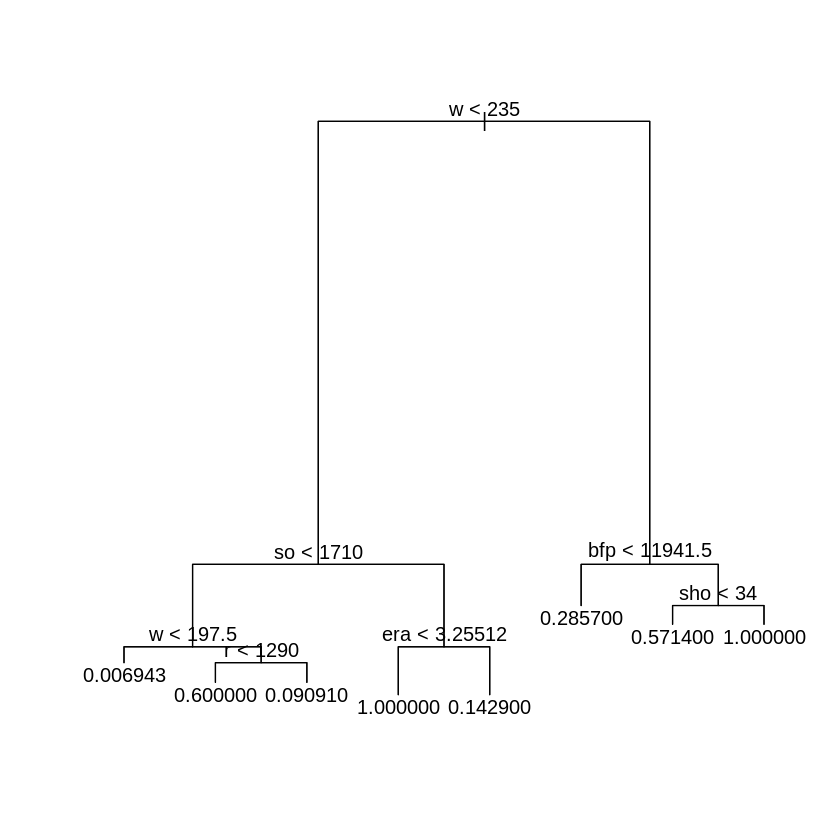

In [80]:
plot(tree.pitching)
text(tree.pitching, pretty = 0)

In [81]:
pitching_tree.pred <- predict(tree.pitching, test_pitching)
pitching_tree.test <- test_pitching$inducted
mean((pitching_tree.pred - pitching_tree.test)^2) #MSE: 0.0034

[1] 0.00342346

In [82]:
pitching_tree.table <- rep(0, length(pitching_tree.pred))
pitching_tree.table[pitching_tree.pred > 0.5] <- 1
table(pitching_tree.table, pitching_tree.test)

                   pitching_tree.test
pitching_tree.table    0    1
                  0 4870    7
                  1   13   14

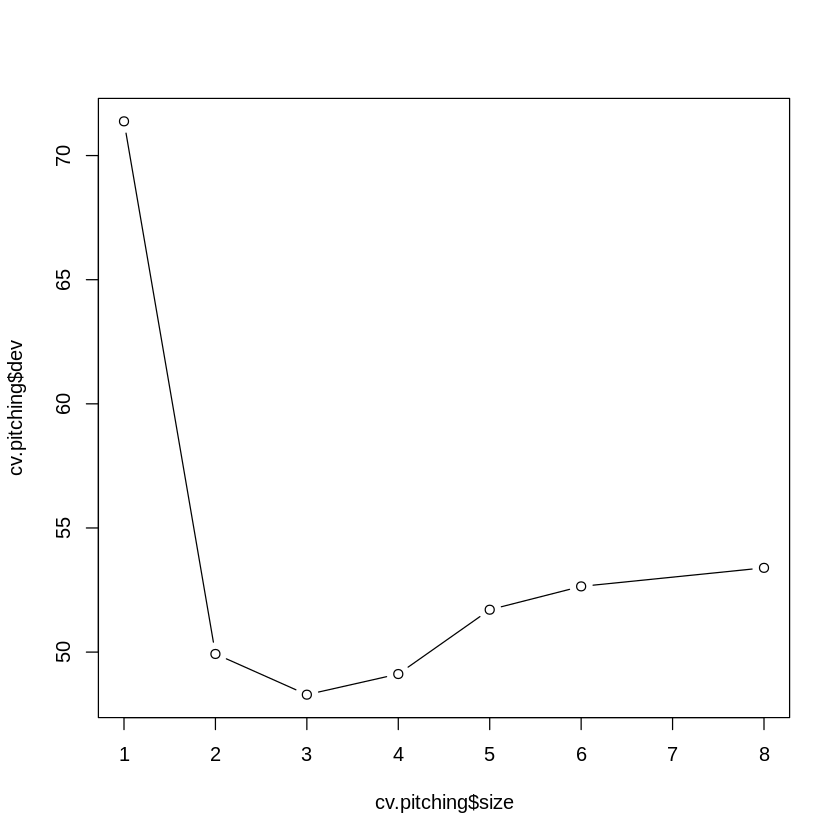

In [83]:
cv.pitching <- cv.tree(tree.pitching)
plot(cv.pitching$size, cv.pitching$dev, type = 'b')

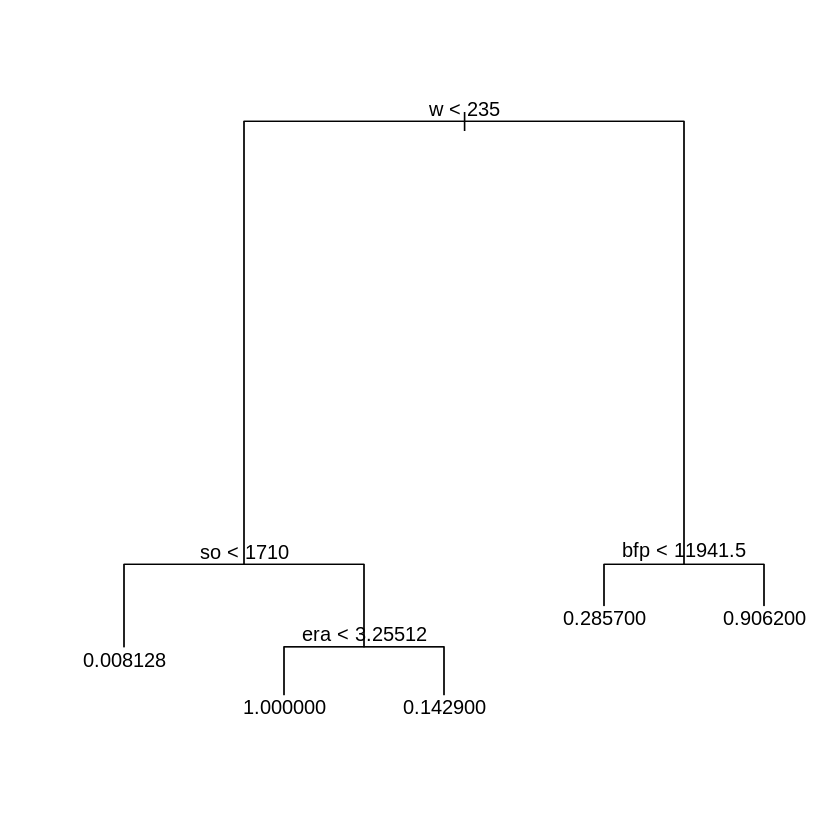

In [84]:
prune.pitching = prune.tree(tree.pitching, best= 5)
plot(prune.pitching)
text(prune.pitching, pretty = 0)

In [85]:
pruned_pitching.pred <- predict(prune.pitching, test_pitching)
mean((pruned_pitching.pred - pitching_tree.test)^2) #0.0039

[1] 0.003920908

In [86]:
pruned_pitching.table <- rep(0, length(pruned_pitching.pred))
pruned_pitching.table[pruned_pitching.pred > 0.5] <- 1
table(pruned_pitching.table, pitching_tree.test)

                     pitching_tree.test
pruned_pitching.table    0    1
                    0 4870    7
                    1   13   14

In [87]:
bag.pitching <- randomForest(inducted ~ ., data = train_pitching, importance = TRUE)
yhatp.bag <- predict(bag.pitching, newdata = test_pitching)
mean((yhatp.bag - pitching_tree.test)^2) #0.0032

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.003208827

In [88]:
yhatp.bag.table <- rep(0, length(yhatp.bag))
yhatp.bag.table[yhatp.bag > 0.5] <- 1
table(yhatp.bag.table, pitching_tree.test)

               pitching_tree.test
yhatp.bag.table    0    1
              0 4878    8
              1    5   13

In [89]:
importance(bag.pitching) #w, era

,%IncMSE,IncNodePurity
V1,0.7169790,3.258321e+00
w,15.6619883,1.016851e+01
l,7.7452213,1.720529e+00
g,8.1195201,1.576974e+00
gs,7.5697308,1.963047e+00
cg,8.1558813,1.193692e+00
sho,14.1944911,4.450619e+00
sv,14.9144461,1.436137e+00
ipouts,10.9260979,4.086725e+00
h,9.3847334,2.349326e+00


In [90]:
rf.pitching <- randomForest(inducted ~ ., data = train_pitching, importance = TRUE)
yhatp.rf <- predict(rf.pitching, newdata = test_pitching)
mean((yhatp.rf - pitching_tree.test)^2) #0.0034

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.003358107

In [91]:
yhatp.rf.table <- rep(0, length(yhatp.rf))
yhatp.rf.table[yhatp.rf > 0.5] <- 1
table(yhatp.rf.table, pitching_tree.test)

              pitching_tree.test
yhatp.rf.table    0    1
             0 4879    8
             1    4   13

In [92]:
importance(rf.pitching) #w, era

,%IncMSE,IncNodePurity
V1,-0.4939597,3.165138e+00
w,15.6100527,1.151500e+01
l,9.1300018,1.763772e+00
g,8.4294908,1.606069e+00
gs,6.3843120,1.792716e+00
cg,7.6411434,1.276336e+00
sho,12.9595157,4.506861e+00
sv,14.9737984,1.424807e+00
ipouts,12.1209375,4.026887e+00
h,9.7525816,2.489397e+00


In [93]:
tree.fielding <- tree(inducted ~ ., data = train_fielding)
summary(tree.fielding) #Number of Terminal Nodes: 13, Residual Mean Deviance: 0.01


Regression tree:
tree(formula = inducted ~ ., data = train_fielding)
Variables actually used in tree construction:
[1] "g"          "a"          "po"         "gs"         "dp"        
[6] "start_year" "fpct"      
Number of terminal nodes:  13 
Residual mean deviance:  0.01038 = 91.5 / 8816 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.875000 -0.002464 -0.002464  0.000000 -0.002464  0.997500 

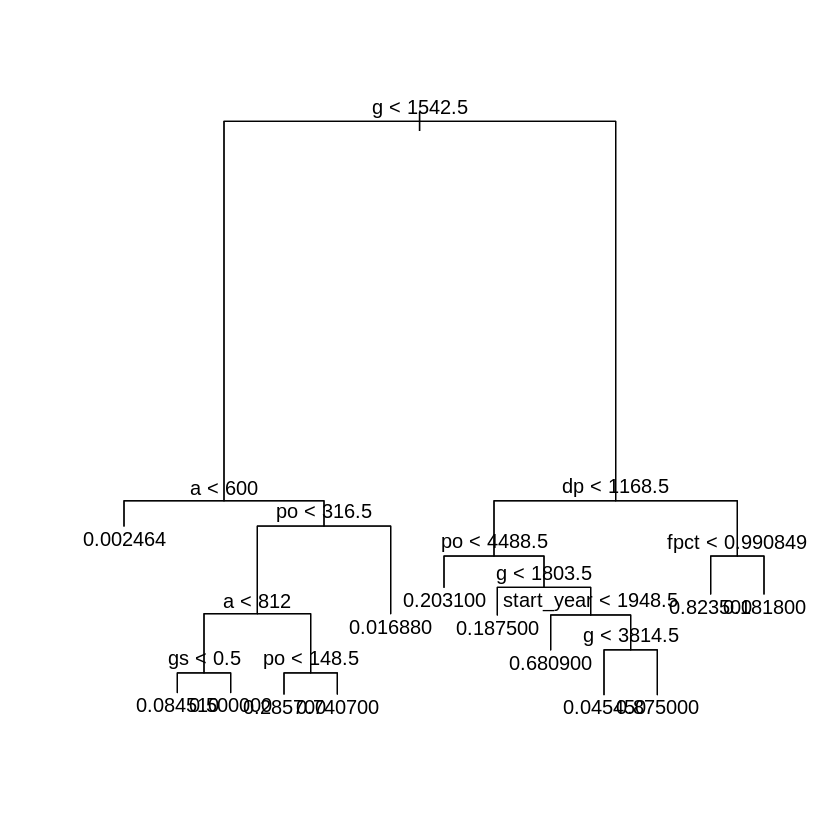

In [94]:
plot(tree.fielding)
text(tree.fielding, pretty = 0)

In [95]:
fielding_tree.pred <- predict(tree.fielding, test_fielding)
fielding_tree.test <- test_fielding$inducted
mean((fielding_tree.pred - fielding_tree.test)^2) #MSE: 0.01

[1] 0.01000017

In [96]:
fielding_tree.table <- rep(0, length(fielding_tree.pred))
fielding_tree.table[fielding_tree.pred > 0.5] <- 1
table(fielding_tree.table, fielding_tree.test)

                   fielding_tree.test
fielding_tree.table    0    1
                  0 8773   34
                  1   59   18

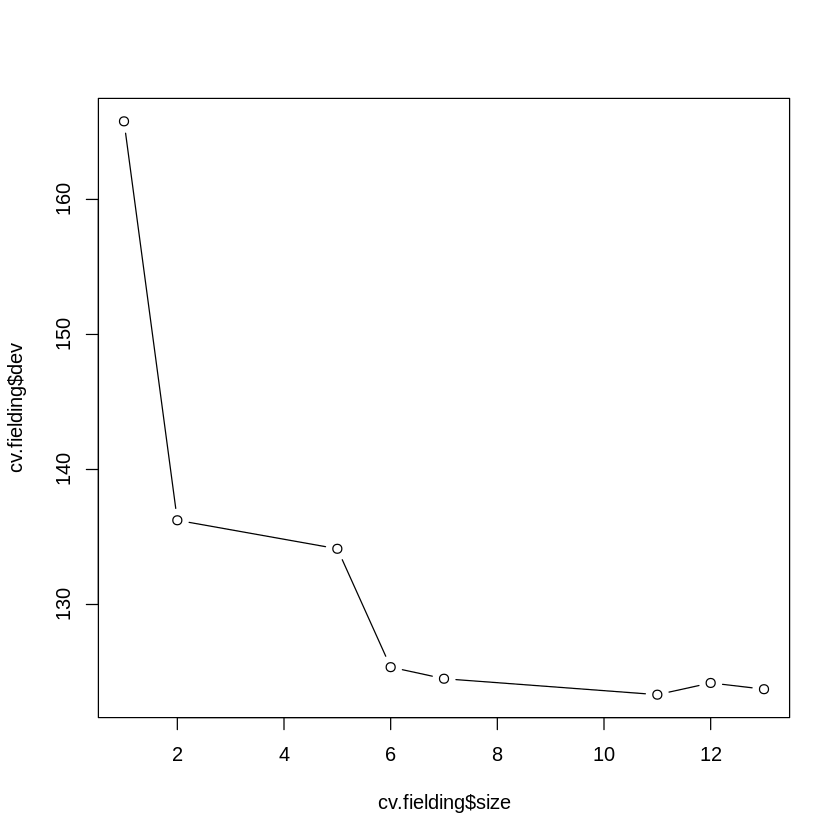

In [97]:
cv.fielding <- cv.tree(tree.fielding)
plot(cv.fielding$size, cv.fielding$dev, type = 'b')

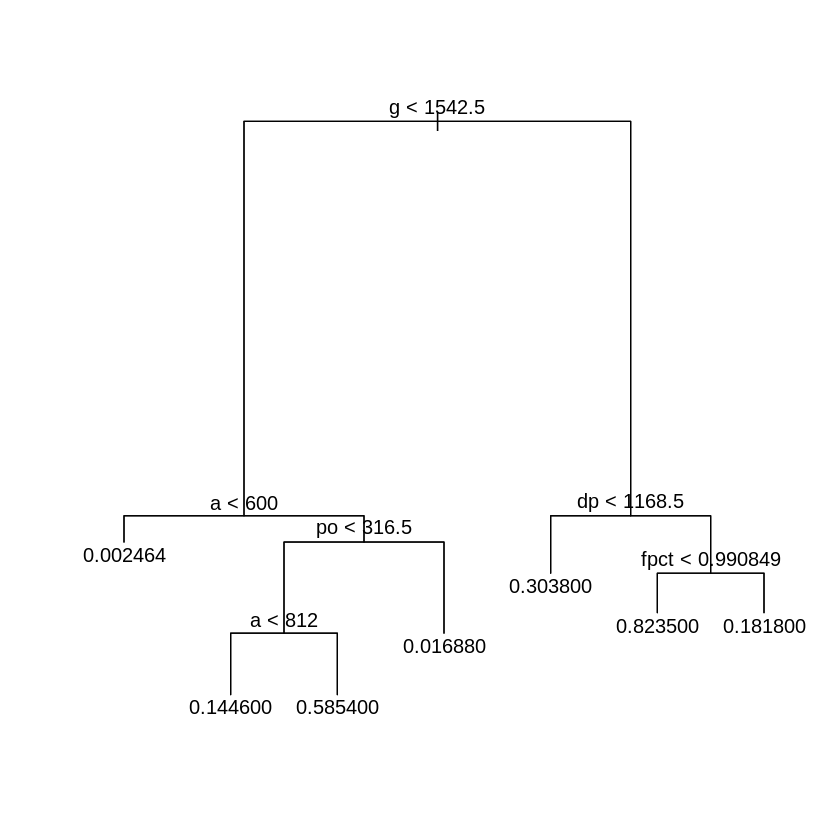

In [98]:
prune.fielding = prune.tree(tree.fielding, best= 7)
plot(prune.fielding)
text(prune.fielding, pretty = 0)

In [99]:
pruned_fielding.pred <- predict(prune.fielding, test_fielding)
mean((pruned_fielding.pred - fielding_tree.test)^2) #0.011

[1] 0.01066576

In [100]:
pruned_fielding.table <- rep(0, length(pruned_fielding.pred))
pruned_fielding.table[pruned_fielding.pred > 0.5] <- 1
table(pruned_fielding.table, fielding_tree.test)

                     fielding_tree.test
pruned_fielding.table    0    1
                    0 8807   43
                    1   25    9

In [101]:
bag.fielding <- randomForest(inducted ~ ., data = train_fielding, importance = TRUE)
yhatf.bag <- predict(bag.fielding, newdata = test_fielding)
mean((yhatf.bag - fielding_tree.test)^2) #0.0066

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.006670019

In [102]:
yhatf.bag.table <- rep(0, length(yhatf.bag))
yhatf.bag.table[yhatf.bag > 0.5] <- 1
table(yhatf.bag.table, fielding_tree.test)

               fielding_tree.test
yhatf.bag.table    0    1
              0 8803   36
              1   29   16

In [103]:
importance(bag.fielding) #po, g, a

,%IncMSE,IncNodePurity
V1,-1.4339980,9.15780072
g,22.9424778,39.92985489
gs,12.7589568,5.10916812
inn_outs,13.1303813,5.56789437
po,35.1032034,25.42183486
a,20.7966755,18.63463883
e,14.2782382,12.80366434
dp,17.8743257,16.85655866
pb,-0.2854244,1.71273829
wp,0.6875878,0.11127182


In [104]:
rf.fielding <- randomForest(inducted ~ ., data = train_fielding, importance = TRUE)
yhatf.rf <- predict(rf.fielding, newdata = test_fielding, type = 'response')
mean((yhatf.rf - fielding_tree.test)^2) #0.0066

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.006784401

In [105]:
yhatf.rf.table <- rep(0, length(yhatf.rf))
yhatf.rf.table[yhatf.rf > 0.5] <- 1
table(yhatf.rf.table, fielding_tree.test)

              fielding_tree.test
yhatf.rf.table    0    1
             0 8802   36
             1   30   16

In [106]:
importance(rf.fielding) # po, g, a

,%IncMSE,IncNodePurity
V1,-2.2517984,9.02509608
g,23.7327349,39.81896286
gs,13.4936301,4.94362445
inn_outs,14.2889013,5.52120509
po,35.1274457,23.97167064
a,20.9290229,19.00748256
e,14.9199592,12.82716190
dp,16.4580952,16.78384358
pb,-0.0114121,1.83059695
wp,0.9658130,0.09108201


In [107]:
str(batting_clean)
str(fielding_clean)
str(pitching_clean)

Classes ‘data.table’ and 'data.frame':	16666 obs. of  24 variables:
 $ V1        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ g         : num  331 3298 437 81 15 ...
 $ ab        : num  4 12364 944 5 21 ...
 $ r         : num  0 2174 102 0 1 ...
 $ h         : num  0 3771 216 0 2 ...
 $ double    : num  0 624 42 0 0 0 0 99 3 67 ...
 $ triple    : num  0 98 6 0 0 0 0 43 3 46 ...
 $ hr        : num  0 755 13 0 0 0 0 11 0 19 ...
 $ rbi       : num  0 2297 94 0 0 ...
 $ sb        : num  0 240 9 0 0 0 1 142 3 93 ...
 $ cs        : num  0 73 8 0 1 0 0 0 0 0 ...
 $ bb        : num  0 1402 86 0 4 ...
 $ so        : num  2 1383 145 3 5 ...
 $ ibb       : num  0 293 3 0 0 0 0 0 0 0 ...
 $ hbp       : num  0 32 0 0 0 0 0 33 0 23 ...
 $ sh        : num  1 21 9 0 0 0 0 93 4 18 ...
 $ sf        : num  0 121 6 0 0 0 0 0 0 0 ...
 $ g_idp     : num  0 328 36 0 1 1 0 0 0 0 ...
 $ start_year: num  2004 1954 1962 1989 2001 ...
 $ inducted  : num  0 1 0 0 0 0 0 0 0 0 ...
 $ bavg      : num  0 0.305 0.2288 0 0.0952 ..